In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### file name for save model log

In [3]:
filename = '06_resnet_50'

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [4]:
USE_CUDA = torch.cuda.is_available() and True 
device = torch.device('cuda' if USE_CUDA else 'cpu')

## data load

In [5]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

In [6]:
train_x = train_x[:int(train_x.shape[0]*0.875)]
train_y = train_y[:int(train_y.shape[0]*0.875)]

val_x = train_x[int(train_x.shape[0]*0.875):]
val_y = train_y[int(train_y.shape[0]*0.875):]

In [7]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((490, 720, 960, 3), (490, 720, 960), (62, 720, 960, 3), (62, 720, 960))

### Cut Mix

In [8]:
def cutmix(image_x, image_y, size_x, size_y):
    w, h = image_x.shape[0], image_x.shape[1]
    
    # 복사할 이미지 랜덤 선택
    cxs, cys = random.randint(0, w-size_x), random.randint(0, h-size_y) # copy x start / copy y start
    cxe, cye = cxs + size_x, cys + size_y # copy x end / copy y end
    
    # 붙여넣을 위치
    xs, ys = random.randint(0, w-size_x), random.randint(0, h-size_y) 
    xe, ye = xs + size_x, ys + size_y
    
    result_x = image_x.copy()
    result_y = image_y.copy()
    result_x[xs:xe, ys:ye] = image_x[cxs:cxe, cys:cye]
    result_y[xs:xe, ys:ye] = image_y[cxs:cxe, cys:cye]
    
    return result_x, result_y

In [9]:
cutmix_index = list(range(len(train_x)))
np.random.shuffle(cutmix_index)

cutmix_num = 200
cutmix_index = cutmix_index[:cutmix_num]

append_x = []
append_y = []

for i in cutmix_index:
    app_x, app_y = cutmix(train_x[i], train_y[i], 300, 300)
    append_x.append(app_x)
    append_y.append(app_y)
    
train_x = np.append(train_x, append_x, axis=0)
train_y = np.append(train_y, append_y, axis=0)

In [10]:
train_x.shape, train_y.shape

((690, 720, 960, 3), (690, 720, 960))

### DeepLab v3 ResNet50 

In [11]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [13]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [14]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [15]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

## train

In [16]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [17]:
# class weight

dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

num_epoch = 100
res = train_X.shape[1] * train_X.shape[2]

In [18]:
for epoch in range(num_epoch):

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))
    
    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        
        model.train()    
    
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
        # progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save path
    if not os.path.isdir(os.getcwd() + '/result/' + filename):
        os.makedirs(os.getcwd() + '/result/' + filename)
    
    save_path = os.getcwd() + '/result/' + filename + '/'
    
    with open(save_path + 'train_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch+1,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            }, save_path + now_time + '_best_weights.pth.tar')


100%|██████████| 345/345 [05:44<00:00,  1.00it/s]


classes           IoU
---------------------
Pole          : 0.151
SignSymbol    : 0.242
Bicyclist     : 0.306
Pedestrian    : 0.268
Building      : 0.588
Fence         : 0.323
Pavement      : 0.604
Road          : 0.842
Car           : 0.609
Sky           : 0.810
Tree          : 0.642
---------------------
Mean IoU      : 0.490
---------------------
train epoch  1
loss : 0.8287   acc : 0.7667   miou : 0.4896
mIoU improved from 0.0000 to 0.4896.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.293
SignSymbol    : 0.464
Bicyclist     : 0.614
Pedestrian    : 0.504
Building      : 0.768
Fence         : 0.584
Pavement      : 0.754
Road          : 0.920
Car           : 0.807
Sky           : 0.882
Tree          : 0.766
---------------------
Mean IoU      : 0.669
---------------------
train epoch  2
loss : 0.4098   acc : 0.8697   miou : 0.6686
mIoU improved from 0.4896 to 0.6686.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.338
SignSymbol    : 0.540
Bicyclist     : 0.672
Pedestrian    : 0.561
Building      : 0.813
Fence         : 0.676
Pavement      : 0.795
Road          : 0.936
Car           : 0.844
Sky           : 0.894
Tree          : 0.794
---------------------
Mean IoU      : 0.715
---------------------
train epoch  3
loss : 0.3301   acc : 0.8922   miou : 0.7150
mIoU improved from 0.6686 to 0.7150.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.374
SignSymbol    : 0.591
Bicyclist     : 0.709
Pedestrian    : 0.590
Building      : 0.841
Fence         : 0.728
Pavement      : 0.823
Road          : 0.944
Car           : 0.868
Sky           : 0.901
Tree          : 0.811
---------------------
Mean IoU      : 0.744
---------------------
train epoch  4
loss : 0.2751   acc : 0.9059   miou : 0.7436
mIoU improved from 0.7150 to 0.7436.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.407
SignSymbol    : 0.636
Bicyclist     : 0.737
Pedestrian    : 0.631
Building      : 0.865
Fence         : 0.778
Pavement      : 0.845
Road          : 0.954
Car           : 0.883
Sky           : 0.906
Tree          : 0.832
---------------------
Mean IoU      : 0.770
---------------------
train epoch  5
loss : 0.2301   acc : 0.9189   miou : 0.7703
mIoU improved from 0.7436 to 0.7703.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.429
SignSymbol    : 0.660
Bicyclist     : 0.753
Pedestrian    : 0.650
Building      : 0.876
Fence         : 0.806
Pavement      : 0.861
Road          : 0.958
Car           : 0.890
Sky           : 0.911
Tree          : 0.844
---------------------
Mean IoU      : 0.785
---------------------
train epoch  6
loss : 0.2060   acc : 0.9255   miou : 0.7853
mIoU improved from 0.7703 to 0.7853.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.449
SignSymbol    : 0.685
Bicyclist     : 0.763
Pedestrian    : 0.667
Building      : 0.886
Fence         : 0.821
Pavement      : 0.870
Road          : 0.962
Car           : 0.896
Sky           : 0.913
Tree          : 0.851
---------------------
Mean IoU      : 0.796
---------------------
train epoch  7
loss : 0.1912   acc : 0.9303   miou : 0.7964
mIoU improved from 0.7853 to 0.7964.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.464
SignSymbol    : 0.707
Bicyclist     : 0.766
Pedestrian    : 0.680
Building      : 0.894
Fence         : 0.839
Pavement      : 0.880
Road          : 0.966
Car           : 0.902
Sky           : 0.914
Tree          : 0.858
---------------------
Mean IoU      : 0.806
---------------------
train epoch  8
loss : 0.1768   acc : 0.9349   miou : 0.8063
mIoU improved from 0.7964 to 0.8063.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.478
SignSymbol    : 0.718
Bicyclist     : 0.782
Pedestrian    : 0.690
Building      : 0.900
Fence         : 0.845
Pavement      : 0.886
Road          : 0.967
Car           : 0.907
Sky           : 0.916
Tree          : 0.864
---------------------
Mean IoU      : 0.814
---------------------
train epoch  9
loss : 0.1674   acc : 0.9379   miou : 0.8140
mIoU improved from 0.8063 to 0.8140.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.491
SignSymbol    : 0.730
Bicyclist     : 0.791
Pedestrian    : 0.701
Building      : 0.904
Fence         : 0.855
Pavement      : 0.890
Road          : 0.969
Car           : 0.911
Sky           : 0.918
Tree          : 0.868
---------------------
Mean IoU      : 0.821
---------------------
train epoch  10
loss : 0.1583   acc : 0.9403   miou : 0.8209
mIoU improved from 0.8140 to 0.8209.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.501
SignSymbol    : 0.744
Bicyclist     : 0.799
Pedestrian    : 0.709
Building      : 0.909
Fence         : 0.865
Pavement      : 0.895
Road          : 0.971
Car           : 0.914
Sky           : 0.920
Tree          : 0.874
---------------------
Mean IoU      : 0.827
---------------------
train epoch  11
loss : 0.1492   acc : 0.9431   miou : 0.8274
mIoU improved from 0.8209 to 0.8274.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.511
SignSymbol    : 0.753
Bicyclist     : 0.804
Pedestrian    : 0.716
Building      : 0.912
Fence         : 0.871
Pavement      : 0.901
Road          : 0.972
Car           : 0.917
Sky           : 0.922
Tree          : 0.878
---------------------
Mean IoU      : 0.832
---------------------
train epoch  12
loss : 0.1431   acc : 0.9450   miou : 0.8325
mIoU improved from 0.8274 to 0.8325.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.519
SignSymbol    : 0.763
Bicyclist     : 0.811
Pedestrian    : 0.724
Building      : 0.915
Fence         : 0.875
Pavement      : 0.902
Road          : 0.972
Car           : 0.919
Sky           : 0.922
Tree          : 0.881
---------------------
Mean IoU      : 0.837
---------------------
train epoch  13
loss : 0.1388   acc : 0.9463   miou : 0.8367
mIoU improved from 0.8325 to 0.8367.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.528
SignSymbol    : 0.769
Bicyclist     : 0.816
Pedestrian    : 0.730
Building      : 0.919
Fence         : 0.882
Pavement      : 0.906
Road          : 0.973
Car           : 0.922
Sky           : 0.923
Tree          : 0.885
---------------------
Mean IoU      : 0.841
---------------------
train epoch  14
loss : 0.1337   acc : 0.9482   miou : 0.8412
mIoU improved from 0.8367 to 0.8412.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.534
SignSymbol    : 0.775
Bicyclist     : 0.819
Pedestrian    : 0.735
Building      : 0.921
Fence         : 0.883
Pavement      : 0.908
Road          : 0.974
Car           : 0.923
Sky           : 0.924
Tree          : 0.888
---------------------
Mean IoU      : 0.844
---------------------
train epoch  15
loss : 0.1293   acc : 0.9493   miou : 0.8440
mIoU improved from 0.8412 to 0.8440.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.541
SignSymbol    : 0.783
Bicyclist     : 0.823
Pedestrian    : 0.742
Building      : 0.924
Fence         : 0.892
Pavement      : 0.911
Road          : 0.974
Car           : 0.926
Sky           : 0.925
Tree          : 0.891
---------------------
Mean IoU      : 0.848
---------------------
train epoch  16
loss : 0.1243   acc : 0.9509   miou : 0.8483
mIoU improved from 0.8440 to 0.8483.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.546
SignSymbol    : 0.789
Bicyclist     : 0.825
Pedestrian    : 0.743
Building      : 0.926
Fence         : 0.894
Pavement      : 0.912
Road          : 0.975
Car           : 0.927
Sky           : 0.926
Tree          : 0.892
---------------------
Mean IoU      : 0.850
---------------------
train epoch  17
loss : 0.1226   acc : 0.9516   miou : 0.8504
mIoU improved from 0.8483 to 0.8504.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.552
SignSymbol    : 0.793
Bicyclist     : 0.827
Pedestrian    : 0.750
Building      : 0.928
Fence         : 0.896
Pavement      : 0.915
Road          : 0.976
Car           : 0.928
Sky           : 0.926
Tree          : 0.894
---------------------
Mean IoU      : 0.853
---------------------
train epoch  18
loss : 0.1191   acc : 0.9528   miou : 0.8532
mIoU improved from 0.8504 to 0.8532.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.557
SignSymbol    : 0.796
Bicyclist     : 0.830
Pedestrian    : 0.752
Building      : 0.929
Fence         : 0.897
Pavement      : 0.917
Road          : 0.976
Car           : 0.930
Sky           : 0.927
Tree          : 0.896
---------------------
Mean IoU      : 0.855
---------------------
train epoch  19
loss : 0.1171   acc : 0.9534   miou : 0.8551
mIoU improved from 0.8532 to 0.8551.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.561
SignSymbol    : 0.800
Bicyclist     : 0.833
Pedestrian    : 0.755
Building      : 0.930
Fence         : 0.900
Pavement      : 0.918
Road          : 0.976
Car           : 0.931
Sky           : 0.928
Tree          : 0.898
---------------------
Mean IoU      : 0.857
---------------------
train epoch  20
loss : 0.1144   acc : 0.9542   miou : 0.8573
mIoU improved from 0.8551 to 0.8573.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.566
SignSymbol    : 0.804
Bicyclist     : 0.838
Pedestrian    : 0.760
Building      : 0.932
Fence         : 0.904
Pavement      : 0.919
Road          : 0.977
Car           : 0.933
Sky           : 0.928
Tree          : 0.900
---------------------
Mean IoU      : 0.860
---------------------
train epoch  21
loss : 0.1119   acc : 0.9550   miou : 0.8601
mIoU improved from 0.8573 to 0.8601.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.571
SignSymbol    : 0.809
Bicyclist     : 0.838
Pedestrian    : 0.762
Building      : 0.933
Fence         : 0.905
Pavement      : 0.922
Road          : 0.977
Car           : 0.934
Sky           : 0.929
Tree          : 0.902
---------------------
Mean IoU      : 0.862
---------------------
train epoch  22
loss : 0.1094   acc : 0.9559   miou : 0.8620
mIoU improved from 0.8601 to 0.8620.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.575
SignSymbol    : 0.812
Bicyclist     : 0.841
Pedestrian    : 0.766
Building      : 0.935
Fence         : 0.907
Pavement      : 0.922
Road          : 0.978
Car           : 0.935
Sky           : 0.929
Tree          : 0.903
---------------------
Mean IoU      : 0.864
---------------------
train epoch  23
loss : 0.1077   acc : 0.9565   miou : 0.8638
mIoU improved from 0.8620 to 0.8638.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.578
SignSymbol    : 0.813
Bicyclist     : 0.843
Pedestrian    : 0.768
Building      : 0.936
Fence         : 0.910
Pavement      : 0.924
Road          : 0.978
Car           : 0.936
Sky           : 0.929
Tree          : 0.904
---------------------
Mean IoU      : 0.865
---------------------
train epoch  24
loss : 0.1061   acc : 0.9570   miou : 0.8653
mIoU improved from 0.8638 to 0.8653.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.582
SignSymbol    : 0.818
Bicyclist     : 0.846
Pedestrian    : 0.773
Building      : 0.937
Fence         : 0.912
Pavement      : 0.925
Road          : 0.978
Car           : 0.937
Sky           : 0.930
Tree          : 0.905
---------------------
Mean IoU      : 0.868
---------------------
train epoch  25
loss : 0.1038   acc : 0.9577   miou : 0.8676
mIoU improved from 0.8653 to 0.8676.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.585
SignSymbol    : 0.821
Bicyclist     : 0.844
Pedestrian    : 0.774
Building      : 0.938
Fence         : 0.911
Pavement      : 0.927
Road          : 0.979
Car           : 0.937
Sky           : 0.930
Tree          : 0.906
---------------------
Mean IoU      : 0.868
---------------------
train epoch  26
loss : 0.1029   acc : 0.9580   miou : 0.8681
mIoU improved from 0.8676 to 0.8681.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.588
SignSymbol    : 0.823
Bicyclist     : 0.846
Pedestrian    : 0.776
Building      : 0.938
Fence         : 0.914
Pavement      : 0.928
Road          : 0.979
Car           : 0.938
Sky           : 0.931
Tree          : 0.908
---------------------
Mean IoU      : 0.870
---------------------
train epoch  27
loss : 0.1013   acc : 0.9586   miou : 0.8699
mIoU improved from 0.8681 to 0.8699.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.591
SignSymbol    : 0.826
Bicyclist     : 0.849
Pedestrian    : 0.777
Building      : 0.940
Fence         : 0.916
Pavement      : 0.928
Road          : 0.979
Car           : 0.939
Sky           : 0.931
Tree          : 0.908
---------------------
Mean IoU      : 0.871
---------------------
train epoch  28
loss : 0.1000   acc : 0.9591   miou : 0.8713
mIoU improved from 0.8699 to 0.8713.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.594
SignSymbol    : 0.828
Bicyclist     : 0.852
Pedestrian    : 0.780
Building      : 0.941
Fence         : 0.916
Pavement      : 0.930
Road          : 0.980
Car           : 0.940
Sky           : 0.931
Tree          : 0.910
---------------------
Mean IoU      : 0.873
---------------------
train epoch  29
loss : 0.0979   acc : 0.9597   miou : 0.8729
mIoU improved from 0.8713 to 0.8729.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.597
SignSymbol    : 0.830
Bicyclist     : 0.854
Pedestrian    : 0.783
Building      : 0.941
Fence         : 0.919
Pavement      : 0.931
Road          : 0.980
Car           : 0.941
Sky           : 0.932
Tree          : 0.911
---------------------
Mean IoU      : 0.874
---------------------
train epoch  30
loss : 0.0969   acc : 0.9601   miou : 0.8744
mIoU improved from 0.8729 to 0.8744.


100%|██████████| 345/345 [05:45<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.600
SignSymbol    : 0.832
Bicyclist     : 0.855
Pedestrian    : 0.786
Building      : 0.942
Fence         : 0.920
Pavement      : 0.932
Road          : 0.980
Car           : 0.942
Sky           : 0.932
Tree          : 0.911
---------------------
Mean IoU      : 0.876
---------------------
train epoch  31
loss : 0.0951   acc : 0.9606   miou : 0.8756
mIoU improved from 0.8744 to 0.8756.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.603
SignSymbol    : 0.833
Bicyclist     : 0.855
Pedestrian    : 0.786
Building      : 0.943
Fence         : 0.921
Pavement      : 0.932
Road          : 0.980
Car           : 0.942
Sky           : 0.932
Tree          : 0.913
---------------------
Mean IoU      : 0.876
---------------------
train epoch  32
loss : 0.0952   acc : 0.9609   miou : 0.8765
mIoU improved from 0.8756 to 0.8765.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.605
SignSymbol    : 0.836
Bicyclist     : 0.856
Pedestrian    : 0.789
Building      : 0.944
Fence         : 0.922
Pavement      : 0.933
Road          : 0.980
Car           : 0.943
Sky           : 0.932
Tree          : 0.913
---------------------
Mean IoU      : 0.878
---------------------
train epoch  33
loss : 0.0933   acc : 0.9613   miou : 0.8777
mIoU improved from 0.8765 to 0.8777.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.607
SignSymbol    : 0.838
Bicyclist     : 0.858
Pedestrian    : 0.790
Building      : 0.944
Fence         : 0.923
Pavement      : 0.934
Road          : 0.981
Car           : 0.944
Sky           : 0.932
Tree          : 0.914
---------------------
Mean IoU      : 0.879
---------------------
train epoch  34
loss : 0.0925   acc : 0.9615   miou : 0.8787
mIoU improved from 0.8777 to 0.8787.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.610
SignSymbol    : 0.841
Bicyclist     : 0.860
Pedestrian    : 0.791
Building      : 0.945
Fence         : 0.925
Pavement      : 0.935
Road          : 0.981
Car           : 0.944
Sky           : 0.933
Tree          : 0.915
---------------------
Mean IoU      : 0.880
---------------------
train epoch  35
loss : 0.0912   acc : 0.9621   miou : 0.8800
mIoU improved from 0.8787 to 0.8800.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.611
SignSymbol    : 0.843
Bicyclist     : 0.861
Pedestrian    : 0.794
Building      : 0.946
Fence         : 0.927
Pavement      : 0.936
Road          : 0.981
Car           : 0.945
Sky           : 0.933
Tree          : 0.916
---------------------
Mean IoU      : 0.881
---------------------
train epoch  36
loss : 0.0904   acc : 0.9623   miou : 0.8810
mIoU improved from 0.8800 to 0.8810.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.611
SignSymbol    : 0.845
Bicyclist     : 0.862
Pedestrian    : 0.796
Building      : 0.946
Fence         : 0.927
Pavement      : 0.936
Road          : 0.981
Car           : 0.945
Sky           : 0.933
Tree          : 0.916
---------------------
Mean IoU      : 0.882
---------------------
train epoch  37
loss : 0.0898   acc : 0.9626   miou : 0.8817
mIoU improved from 0.8810 to 0.8817.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.616
SignSymbol    : 0.846
Bicyclist     : 0.864
Pedestrian    : 0.797
Building      : 0.947
Fence         : 0.927
Pavement      : 0.937
Road          : 0.981
Car           : 0.946
Sky           : 0.934
Tree          : 0.917
---------------------
Mean IoU      : 0.883
---------------------
train epoch  38
loss : 0.0885   acc : 0.9631   miou : 0.8829
mIoU improved from 0.8817 to 0.8829.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.618
SignSymbol    : 0.847
Bicyclist     : 0.864
Pedestrian    : 0.798
Building      : 0.947
Fence         : 0.928
Pavement      : 0.938
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.918
---------------------
Mean IoU      : 0.884
---------------------
train epoch  39
loss : 0.0880   acc : 0.9634   miou : 0.8838
mIoU improved from 0.8829 to 0.8838.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.620
SignSymbol    : 0.849
Bicyclist     : 0.867
Pedestrian    : 0.799
Building      : 0.948
Fence         : 0.928
Pavement      : 0.938
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.919
---------------------
Mean IoU      : 0.885
---------------------
train epoch  40
loss : 0.0869   acc : 0.9636   miou : 0.8846
mIoU improved from 0.8838 to 0.8846.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.623
SignSymbol    : 0.850
Bicyclist     : 0.868
Pedestrian    : 0.801
Building      : 0.949
Fence         : 0.929
Pavement      : 0.939
Road          : 0.982
Car           : 0.947
Sky           : 0.934
Tree          : 0.920
---------------------
Mean IoU      : 0.886
---------------------
train epoch  41
loss : 0.0861   acc : 0.9639   miou : 0.8856
mIoU improved from 0.8846 to 0.8856.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.623
SignSymbol    : 0.851
Bicyclist     : 0.867
Pedestrian    : 0.802
Building      : 0.949
Fence         : 0.931
Pavement      : 0.940
Road          : 0.982
Car           : 0.948
Sky           : 0.935
Tree          : 0.920
---------------------
Mean IoU      : 0.886
---------------------
train epoch  42
loss : 0.0852   acc : 0.9642   miou : 0.8862
mIoU improved from 0.8856 to 0.8862.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.625
SignSymbol    : 0.852
Bicyclist     : 0.869
Pedestrian    : 0.804
Building      : 0.950
Fence         : 0.932
Pavement      : 0.940
Road          : 0.982
Car           : 0.949
Sky           : 0.935
Tree          : 0.920
---------------------
Mean IoU      : 0.887
---------------------
train epoch  43
loss : 0.0845   acc : 0.9644   miou : 0.8871
mIoU improved from 0.8862 to 0.8871.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.626
SignSymbol    : 0.854
Bicyclist     : 0.870
Pedestrian    : 0.806
Building      : 0.950
Fence         : 0.932
Pavement      : 0.941
Road          : 0.982
Car           : 0.949
Sky           : 0.935
Tree          : 0.921
---------------------
Mean IoU      : 0.888
---------------------
train epoch  44
loss : 0.0836   acc : 0.9648   miou : 0.8879
mIoU improved from 0.8871 to 0.8879.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.628
SignSymbol    : 0.855
Bicyclist     : 0.871
Pedestrian    : 0.806
Building      : 0.950
Fence         : 0.932
Pavement      : 0.941
Road          : 0.982
Car           : 0.949
Sky           : 0.935
Tree          : 0.922
---------------------
Mean IoU      : 0.888
---------------------
train epoch  45
loss : 0.0831   acc : 0.9649   miou : 0.8884
mIoU improved from 0.8879 to 0.8884.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.631
SignSymbol    : 0.857
Bicyclist     : 0.873
Pedestrian    : 0.808
Building      : 0.951
Fence         : 0.933
Pavement      : 0.941
Road          : 0.982
Car           : 0.950
Sky           : 0.935
Tree          : 0.922
---------------------
Mean IoU      : 0.889
---------------------
train epoch  46
loss : 0.0828   acc : 0.9651   miou : 0.8893
mIoU improved from 0.8884 to 0.8893.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.632
SignSymbol    : 0.858
Bicyclist     : 0.873
Pedestrian    : 0.808
Building      : 0.951
Fence         : 0.933
Pavement      : 0.942
Road          : 0.983
Car           : 0.950
Sky           : 0.935
Tree          : 0.923
---------------------
Mean IoU      : 0.890
---------------------
train epoch  47
loss : 0.0822   acc : 0.9653   miou : 0.8897
mIoU improved from 0.8893 to 0.8897.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.634
SignSymbol    : 0.858
Bicyclist     : 0.873
Pedestrian    : 0.809
Building      : 0.951
Fence         : 0.934
Pavement      : 0.943
Road          : 0.983
Car           : 0.950
Sky           : 0.936
Tree          : 0.924
---------------------
Mean IoU      : 0.890
---------------------
train epoch  48
loss : 0.0818   acc : 0.9655   miou : 0.8904
mIoU improved from 0.8897 to 0.8904.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.636
SignSymbol    : 0.860
Bicyclist     : 0.874
Pedestrian    : 0.810
Building      : 0.952
Fence         : 0.935
Pavement      : 0.943
Road          : 0.983
Car           : 0.951
Sky           : 0.936
Tree          : 0.924
---------------------
Mean IoU      : 0.891
---------------------
train epoch  49
loss : 0.0805   acc : 0.9659   miou : 0.8912
mIoU improved from 0.8904 to 0.8912.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.637
SignSymbol    : 0.861
Bicyclist     : 0.874
Pedestrian    : 0.811
Building      : 0.952
Fence         : 0.935
Pavement      : 0.944
Road          : 0.983
Car           : 0.951
Sky           : 0.936
Tree          : 0.924
---------------------
Mean IoU      : 0.892
---------------------
train epoch  50
loss : 0.0802   acc : 0.9660   miou : 0.8916
mIoU improved from 0.8912 to 0.8916.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.637
SignSymbol    : 0.862
Bicyclist     : 0.876
Pedestrian    : 0.813
Building      : 0.953
Fence         : 0.936
Pavement      : 0.944
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.925
---------------------
Mean IoU      : 0.892
---------------------
train epoch  51
loss : 0.0797   acc : 0.9662   miou : 0.8924
mIoU improved from 0.8916 to 0.8924.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.639
SignSymbol    : 0.864
Bicyclist     : 0.876
Pedestrian    : 0.814
Building      : 0.953
Fence         : 0.937
Pavement      : 0.945
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.925
---------------------
Mean IoU      : 0.893
---------------------
train epoch  52
loss : 0.0791   acc : 0.9664   miou : 0.8931
mIoU improved from 0.8924 to 0.8931.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.641
SignSymbol    : 0.865
Bicyclist     : 0.876
Pedestrian    : 0.814
Building      : 0.953
Fence         : 0.937
Pavement      : 0.945
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  53
loss : 0.0786   acc : 0.9665   miou : 0.8935
mIoU improved from 0.8931 to 0.8935.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.642
SignSymbol    : 0.864
Bicyclist     : 0.877
Pedestrian    : 0.815
Building      : 0.954
Fence         : 0.937
Pavement      : 0.945
Road          : 0.983
Car           : 0.952
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.894
---------------------
train epoch  54
loss : 0.0784   acc : 0.9668   miou : 0.8939
mIoU improved from 0.8935 to 0.8939.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.643
SignSymbol    : 0.865
Bicyclist     : 0.879
Pedestrian    : 0.816
Building      : 0.954
Fence         : 0.939
Pavement      : 0.946
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.895
---------------------
train epoch  55
loss : 0.0782   acc : 0.9669   miou : 0.8946
mIoU improved from 0.8939 to 0.8946.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.866
Bicyclist     : 0.879
Pedestrian    : 0.816
Building      : 0.954
Fence         : 0.939
Pavement      : 0.946
Road          : 0.984
Car           : 0.953
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.895
---------------------
train epoch  56
loss : 0.0775   acc : 0.9669   miou : 0.8949
mIoU improved from 0.8946 to 0.8949.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.867
Bicyclist     : 0.880
Pedestrian    : 0.817
Building      : 0.954
Fence         : 0.938
Pavement      : 0.946
Road          : 0.983
Car           : 0.954
Sky           : 0.936
Tree          : 0.927
---------------------
Mean IoU      : 0.895
---------------------
train epoch  57
loss : 0.0775   acc : 0.9670   miou : 0.8951
mIoU improved from 0.8949 to 0.8951.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.645
SignSymbol    : 0.868
Bicyclist     : 0.880
Pedestrian    : 0.819
Building      : 0.955
Fence         : 0.939
Pavement      : 0.947
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.927
---------------------
Mean IoU      : 0.896
---------------------
train epoch  58
loss : 0.0763   acc : 0.9673   miou : 0.8958
mIoU improved from 0.8951 to 0.8958.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.869
Bicyclist     : 0.881
Pedestrian    : 0.819
Building      : 0.955
Fence         : 0.940
Pavement      : 0.947
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.896
---------------------
train epoch  59
loss : 0.0761   acc : 0.9675   miou : 0.8965
mIoU improved from 0.8958 to 0.8965.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.649
SignSymbol    : 0.870
Bicyclist     : 0.881
Pedestrian    : 0.820
Building      : 0.956
Fence         : 0.940
Pavement      : 0.947
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.897
---------------------
train epoch  60
loss : 0.0756   acc : 0.9678   miou : 0.8970
mIoU improved from 0.8965 to 0.8970.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.649
SignSymbol    : 0.871
Bicyclist     : 0.882
Pedestrian    : 0.821
Building      : 0.956
Fence         : 0.940
Pavement      : 0.947
Road          : 0.984
Car           : 0.955
Sky           : 0.937
Tree          : 0.928
---------------------
Mean IoU      : 0.897
---------------------
train epoch  61
loss : 0.0752   acc : 0.9677   miou : 0.8972


  0%|          | 0/345 [00:00<?, ?it/s]

mIoU improved from 0.8970 to 0.8972.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.652
SignSymbol    : 0.871
Bicyclist     : 0.883
Pedestrian    : 0.821
Building      : 0.956
Fence         : 0.941
Pavement      : 0.948
Road          : 0.984
Car           : 0.955
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  62
loss : 0.0747   acc : 0.9680   miou : 0.8980
mIoU improved from 0.8972 to 0.8980.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.652
SignSymbol    : 0.873
Bicyclist     : 0.883
Pedestrian    : 0.823
Building      : 0.956
Fence         : 0.942
Pavement      : 0.948
Road          : 0.984
Car           : 0.955
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  63
loss : 0.0742   acc : 0.9681   miou : 0.8985
mIoU improved from 0.8980 to 0.8985.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.872
Bicyclist     : 0.883
Pedestrian    : 0.823
Building      : 0.957
Fence         : 0.942
Pavement      : 0.949
Road          : 0.984
Car           : 0.956
Sky           : 0.937
Tree          : 0.929
---------------------
Mean IoU      : 0.899
---------------------
train epoch  64
loss : 0.0738   acc : 0.9683   miou : 0.8987
mIoU improved from 0.8985 to 0.8987.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.654
SignSymbol    : 0.874
Bicyclist     : 0.885
Pedestrian    : 0.825
Building      : 0.957
Fence         : 0.943
Pavement      : 0.949
Road          : 0.984
Car           : 0.956
Sky           : 0.937
Tree          : 0.930
---------------------
Mean IoU      : 0.899
---------------------
train epoch  65
loss : 0.0737   acc : 0.9684   miou : 0.8994
mIoU improved from 0.8987 to 0.8994.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.655
SignSymbol    : 0.874
Bicyclist     : 0.884
Pedestrian    : 0.825
Building      : 0.957
Fence         : 0.942
Pavement      : 0.949
Road          : 0.984
Car           : 0.956
Sky           : 0.938
Tree          : 0.930
---------------------
Mean IoU      : 0.899
---------------------
train epoch  66
loss : 0.0734   acc : 0.9685   miou : 0.8994
mIoU improved from 0.8994 to 0.8994.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.875
Bicyclist     : 0.885
Pedestrian    : 0.825
Building      : 0.957
Fence         : 0.943
Pavement      : 0.949
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.930
---------------------
Mean IoU      : 0.900
---------------------
train epoch  67
loss : 0.0726   acc : 0.9687   miou : 0.9000
mIoU improved from 0.8994 to 0.9000.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.876
Bicyclist     : 0.886
Pedestrian    : 0.826
Building      : 0.958
Fence         : 0.943
Pavement      : 0.950
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.900
---------------------
train epoch  68
loss : 0.0724   acc : 0.9689   miou : 0.9005
mIoU improved from 0.9000 to 0.9005.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.876
Bicyclist     : 0.887
Pedestrian    : 0.827
Building      : 0.958
Fence         : 0.943
Pavement      : 0.950
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.901
---------------------
train epoch  69
loss : 0.0720   acc : 0.9689   miou : 0.9009
mIoU improved from 0.9005 to 0.9009.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.659
SignSymbol    : 0.878
Bicyclist     : 0.887
Pedestrian    : 0.827
Building      : 0.958
Fence         : 0.944
Pavement      : 0.950
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.901
---------------------
train epoch  70
loss : 0.0714   acc : 0.9691   miou : 0.9012
mIoU improved from 0.9009 to 0.9012.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.659
SignSymbol    : 0.878
Bicyclist     : 0.888
Pedestrian    : 0.828
Building      : 0.958
Fence         : 0.944
Pavement      : 0.951
Road          : 0.985
Car           : 0.957
Sky           : 0.938
Tree          : 0.931
---------------------
Mean IoU      : 0.902
---------------------
train epoch  71
loss : 0.0714   acc : 0.9692   miou : 0.9017
mIoU improved from 0.9012 to 0.9017.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.661
SignSymbol    : 0.878
Bicyclist     : 0.888
Pedestrian    : 0.829
Building      : 0.958
Fence         : 0.945
Pavement      : 0.951
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.902
---------------------
train epoch  72
loss : 0.0709   acc : 0.9693   miou : 0.9020
mIoU improved from 0.9017 to 0.9020.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.661
SignSymbol    : 0.879
Bicyclist     : 0.889
Pedestrian    : 0.829
Building      : 0.959
Fence         : 0.945
Pavement      : 0.951
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.902
---------------------
train epoch  73
loss : 0.0709   acc : 0.9693   miou : 0.9022
mIoU improved from 0.9020 to 0.9022.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.880
Bicyclist     : 0.889
Pedestrian    : 0.829
Building      : 0.959
Fence         : 0.945
Pavement      : 0.951
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.903
---------------------
train epoch  74
loss : 0.0708   acc : 0.9695   miou : 0.9026
mIoU improved from 0.9022 to 0.9026.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.880
Bicyclist     : 0.890
Pedestrian    : 0.830
Building      : 0.959
Fence         : 0.945
Pavement      : 0.952
Road          : 0.985
Car           : 0.958
Sky           : 0.938
Tree          : 0.932
---------------------
Mean IoU      : 0.903
---------------------
train epoch  75
loss : 0.0704   acc : 0.9695   miou : 0.9030


  0%|          | 0/345 [00:00<?, ?it/s]

mIoU improved from 0.9026 to 0.9030.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.664
SignSymbol    : 0.881
Bicyclist     : 0.891
Pedestrian    : 0.831
Building      : 0.959
Fence         : 0.946
Pavement      : 0.952
Road          : 0.985
Car           : 0.958
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.903
---------------------
train epoch  76
loss : 0.0700   acc : 0.9697   miou : 0.9035
mIoU improved from 0.9030 to 0.9035.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.881
Bicyclist     : 0.890
Pedestrian    : 0.831
Building      : 0.959
Fence         : 0.947
Pavement      : 0.952
Road          : 0.985
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.904
---------------------
train epoch  77
loss : 0.0694   acc : 0.9698   miou : 0.9037
mIoU improved from 0.9035 to 0.9037.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.882
Bicyclist     : 0.891
Pedestrian    : 0.832
Building      : 0.960
Fence         : 0.946
Pavement      : 0.952
Road          : 0.985
Car           : 0.959
Sky           : 0.938
Tree          : 0.933
---------------------
Mean IoU      : 0.904
---------------------
train epoch  78
loss : 0.0695   acc : 0.9699   miou : 0.9039
mIoU improved from 0.9037 to 0.9039.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.882
Bicyclist     : 0.892
Pedestrian    : 0.833
Building      : 0.960
Fence         : 0.946
Pavement      : 0.953
Road          : 0.985
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.904
---------------------
train epoch  79
loss : 0.0691   acc : 0.9700   miou : 0.9043
mIoU improved from 0.9039 to 0.9043.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.667
SignSymbol    : 0.882
Bicyclist     : 0.892
Pedestrian    : 0.833
Building      : 0.960
Fence         : 0.947
Pavement      : 0.953
Road          : 0.986
Car           : 0.959
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.905
---------------------
train epoch  80
loss : 0.0687   acc : 0.9701   miou : 0.9046
mIoU improved from 0.9043 to 0.9046.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.669
SignSymbol    : 0.884
Bicyclist     : 0.893
Pedestrian    : 0.833
Building      : 0.960
Fence         : 0.947
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.905
---------------------
train epoch  81
loss : 0.0684   acc : 0.9703   miou : 0.9052
mIoU improved from 0.9046 to 0.9052.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.669
SignSymbol    : 0.884
Bicyclist     : 0.892
Pedestrian    : 0.834
Building      : 0.960
Fence         : 0.947
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.905
---------------------
train epoch  82
loss : 0.0683   acc : 0.9703   miou : 0.9052
mIoU improved from 0.9052 to 0.9052.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.669
SignSymbol    : 0.884
Bicyclist     : 0.893
Pedestrian    : 0.834
Building      : 0.960
Fence         : 0.947
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.905
---------------------
train epoch  83
loss : 0.0685   acc : 0.9703   miou : 0.9053
mIoU improved from 0.9052 to 0.9053.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.670
SignSymbol    : 0.885
Bicyclist     : 0.893
Pedestrian    : 0.835
Building      : 0.961
Fence         : 0.948
Pavement      : 0.953
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.906
---------------------
train epoch  84
loss : 0.0677   acc : 0.9705   miou : 0.9058
mIoU improved from 0.9053 to 0.9058.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.671
SignSymbol    : 0.886
Bicyclist     : 0.894
Pedestrian    : 0.835
Building      : 0.961
Fence         : 0.948
Pavement      : 0.954
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.935
---------------------
Mean IoU      : 0.906
---------------------
train epoch  85
loss : 0.0673   acc : 0.9706   miou : 0.9061
mIoU improved from 0.9058 to 0.9061.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.671
SignSymbol    : 0.886
Bicyclist     : 0.894
Pedestrian    : 0.836
Building      : 0.961
Fence         : 0.948
Pavement      : 0.954
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.934
---------------------
Mean IoU      : 0.906
---------------------
train epoch  86
loss : 0.0676   acc : 0.9706   miou : 0.9063
mIoU improved from 0.9061 to 0.9063.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.672
SignSymbol    : 0.886
Bicyclist     : 0.895
Pedestrian    : 0.836
Building      : 0.961
Fence         : 0.948
Pavement      : 0.954
Road          : 0.986
Car           : 0.960
Sky           : 0.939
Tree          : 0.935
---------------------
Mean IoU      : 0.907
---------------------
train epoch  87
loss : 0.0671   acc : 0.9708   miou : 0.9066
mIoU improved from 0.9063 to 0.9066.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.672
SignSymbol    : 0.888
Bicyclist     : 0.894
Pedestrian    : 0.838
Building      : 0.961
Fence         : 0.948
Pavement      : 0.954
Road          : 0.986
Car           : 0.961
Sky           : 0.939
Tree          : 0.935
---------------------
Mean IoU      : 0.907
---------------------
train epoch  88
loss : 0.0671   acc : 0.9708   miou : 0.9069
mIoU improved from 0.9066 to 0.9069.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.673
SignSymbol    : 0.887
Bicyclist     : 0.895
Pedestrian    : 0.837
Building      : 0.961
Fence         : 0.949
Pavement      : 0.955
Road          : 0.986
Car           : 0.961
Sky           : 0.939
Tree          : 0.935
---------------------
Mean IoU      : 0.907
---------------------
train epoch  89
loss : 0.0667   acc : 0.9709   miou : 0.9071
mIoU improved from 0.9069 to 0.9071.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.674
SignSymbol    : 0.887
Bicyclist     : 0.896
Pedestrian    : 0.838
Building      : 0.962
Fence         : 0.949
Pavement      : 0.955
Road          : 0.986
Car           : 0.961
Sky           : 0.939
Tree          : 0.935
---------------------
Mean IoU      : 0.908
---------------------
train epoch  90
loss : 0.0666   acc : 0.9710   miou : 0.9076


  0%|          | 0/345 [00:00<?, ?it/s]

mIoU improved from 0.9071 to 0.9076.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.675
SignSymbol    : 0.888
Bicyclist     : 0.896
Pedestrian    : 0.839
Building      : 0.962
Fence         : 0.949
Pavement      : 0.955
Road          : 0.986
Car           : 0.961
Sky           : 0.939
Tree          : 0.936
---------------------
Mean IoU      : 0.908
---------------------
train epoch  91
loss : 0.0662   acc : 0.9711   miou : 0.9078
mIoU improved from 0.9076 to 0.9078.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.674
SignSymbol    : 0.888
Bicyclist     : 0.896
Pedestrian    : 0.839
Building      : 0.962
Fence         : 0.950
Pavement      : 0.955
Road          : 0.986
Car           : 0.961
Sky           : 0.939
Tree          : 0.936
---------------------
Mean IoU      : 0.908
---------------------
train epoch  92
loss : 0.0661   acc : 0.9712   miou : 0.9079
mIoU improved from 0.9078 to 0.9079.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.676
SignSymbol    : 0.889
Bicyclist     : 0.897
Pedestrian    : 0.839
Building      : 0.962
Fence         : 0.950
Pavement      : 0.955
Road          : 0.986
Car           : 0.961
Sky           : 0.940
Tree          : 0.936
---------------------
Mean IoU      : 0.908
---------------------
train epoch  93
loss : 0.0658   acc : 0.9713   miou : 0.9082
mIoU improved from 0.9079 to 0.9082.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.677
SignSymbol    : 0.889
Bicyclist     : 0.897
Pedestrian    : 0.839
Building      : 0.962
Fence         : 0.950
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.939
Tree          : 0.936
---------------------
Mean IoU      : 0.909
---------------------
train epoch  94
loss : 0.0655   acc : 0.9714   miou : 0.9085
mIoU improved from 0.9082 to 0.9085.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.677
SignSymbol    : 0.890
Bicyclist     : 0.897
Pedestrian    : 0.840
Building      : 0.962
Fence         : 0.951
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.909
---------------------
train epoch  95
loss : 0.0650   acc : 0.9715   miou : 0.9089
mIoU improved from 0.9085 to 0.9089.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.677
SignSymbol    : 0.891
Bicyclist     : 0.898
Pedestrian    : 0.840
Building      : 0.962
Fence         : 0.950
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.909
---------------------
train epoch  96
loss : 0.0650   acc : 0.9715   miou : 0.9090
mIoU improved from 0.9089 to 0.9090.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.679
SignSymbol    : 0.891
Bicyclist     : 0.898
Pedestrian    : 0.840
Building      : 0.963
Fence         : 0.951
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.909
---------------------
train epoch  97
loss : 0.0650   acc : 0.9715   miou : 0.9092
mIoU improved from 0.9090 to 0.9092.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.679
SignSymbol    : 0.890
Bicyclist     : 0.898
Pedestrian    : 0.841
Building      : 0.963
Fence         : 0.951
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.909
---------------------
train epoch  98
loss : 0.0649   acc : 0.9716   miou : 0.9094
mIoU improved from 0.9092 to 0.9094.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.679
SignSymbol    : 0.891
Bicyclist     : 0.897
Pedestrian    : 0.841
Building      : 0.963
Fence         : 0.951
Pavement      : 0.956
Road          : 0.986
Car           : 0.962
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.909
---------------------
train epoch  99
loss : 0.0646   acc : 0.9717   miou : 0.9095
mIoU improved from 0.9094 to 0.9095.


100%|██████████| 345/345 [05:46<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.680
SignSymbol    : 0.892
Bicyclist     : 0.898
Pedestrian    : 0.841
Building      : 0.963
Fence         : 0.952
Pavement      : 0.956
Road          : 0.986
Car           : 0.963
Sky           : 0.940
Tree          : 0.937
---------------------
Mean IoU      : 0.910
---------------------
train epoch  100
loss : 0.0642   acc : 0.9718   miou : 0.9099
mIoU improved from 0.9095 to 0.9099.


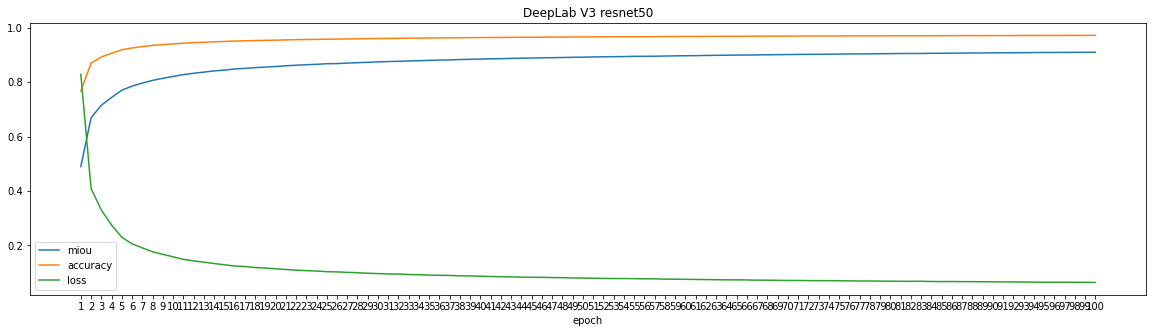

In [20]:
log_epoch = pd.read_csv('result/' + filename + '/train_log_epoch.csv', names = ['epoch', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(20, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

## validation

In [21]:
val_X = torch.tensor(val_x, dtype=torch.float32)
val_Y = torch.tensor(val_y, dtype=torch.long)

val_data = torch.utils.data.TensorDataset(val_X.permute(dims=(0, 3, 1, 2)), val_Y)

val_data = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)

In [22]:
# Load best model

save_path = os.getcwd() + '/result/' + filename + '/'
result = [file for file in sorted(os.listdir(save_path), reverse=False) if file[13:] == 'checkpoint.pth.tar' ]

In [23]:
len(result)

100

In [24]:
for i, file in enumerate(result):

    checkpoint = torch.load(save_path + file) 
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], file))

    model.eval()

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')
    iou = iouCalc(classLabels, validClasses, voidClass = 11)

    batch_loss = 0.0
    for batch, (x, y) in enumerate(tqdm(val_data, total=len(val_data))):

        x = x.to(device)
        y = y.to(device)

        # forward
        outputs = model(x)
        outputs = outputs['out']

        preds = torch.argmax(outputs, 1)

        # cross-entropy loss
        loss = criterion(outputs, y)

        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))

        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)

        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)

    miou = iou.outputScores()


    with open(save_path + 'val_log_epoch.csv', 'a') as epoch_log:
        epoch_log.write('{}, {}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                i+1, file, loss_running.avg, acc_running.avg, miou))

    print('validataion')
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

  2%|▏         | 1/62 [00:00<00:07,  7.96it/s]

Loaded best model weights (epoch 1) from 210606_03:35_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.269
SignSymbol    : 0.344
Bicyclist     : 0.587
Pedestrian    : 0.399
Building      : 0.704
Fence         : 0.553
Pavement      : 0.781
Road          : 0.919
Car           : 0.708
Sky           : 0.857
Tree          : 0.747
---------------------
Mean IoU      : 0.624
---------------------
validataion
loss : 0.4561   acc : 0.8440   miou : 0.6244
Loaded best model weights (epoch 2) from 210606_03:41_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.304
SignSymbol    : 0.494
Bicyclist     : 0.606
Pedestrian    : 0.525
Building      : 0.788
Fence         : 0.677
Pavement      : 0.792
Road          : 0.929
Car           : 0.843
Sky           : 0.886
Tree          : 0.787
---------------------
Mean IoU      : 0.694
---------------------
validataion
loss : 0.3171   acc : 0.8811   miou : 0.6938
Loaded best model weights (epoch 3) from 210606_03:47_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.387
SignSymbol    : 0.593
Bicyclist     : 0.685
Pedestrian    : 0.620
Building      : 0.838
Fence         : 0.650
Pavement      : 0.824
Road          : 0.940
Car           : 0.878
Sky           : 0.907
Tree          : 0.815
---------------------
Mean IoU      : 0.740
---------------------
validataion
loss : 0.2745   acc : 0.9044   miou : 0.7398
Loaded best model weights (epoch 4) from 210606_03:52_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.391
SignSymbol    : 0.632
Bicyclist     : 0.686
Pedestrian    : 0.634
Building      : 0.855
Fence         : 0.708
Pavement      : 0.863
Road          : 0.953
Car           : 0.871
Sky           : 0.912
Tree          : 0.823
---------------------
Mean IoU      : 0.757
---------------------
validataion
loss : 0.2388   acc : 0.9148   miou : 0.7570
Loaded best model weights (epoch 5) from 210606_03:58_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.350
SignSymbol    : 0.580
Bicyclist     : 0.742
Pedestrian    : 0.625
Building      : 0.836
Fence         : 0.757
Pavement      : 0.863
Road          : 0.955
Car           : 0.895
Sky           : 0.908
Tree          : 0.833
---------------------
Mean IoU      : 0.759
---------------------
validataion
loss : 0.2176   acc : 0.9118   miou : 0.7586
Loaded best model weights (epoch 6) from 210606_04:04_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.447
SignSymbol    : 0.716
Bicyclist     : 0.699
Pedestrian    : 0.677
Building      : 0.873
Fence         : 0.783
Pavement      : 0.875
Road          : 0.956
Car           : 0.896
Sky           : 0.917
Tree          : 0.850
---------------------
Mean IoU      : 0.790
---------------------
validataion
loss : 0.1907   acc : 0.9262   miou : 0.7900
Loaded best model weights (epoch 7) from 210606_04:10_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.451
SignSymbol    : 0.686
Bicyclist     : 0.742
Pedestrian    : 0.688
Building      : 0.875
Fence         : 0.798
Pavement      : 0.874
Road          : 0.956
Car           : 0.905
Sky           : 0.904
Tree          : 0.845
---------------------
Mean IoU      : 0.793
---------------------
validataion
loss : 0.1830   acc : 0.9251   miou : 0.7930
Loaded best model weights (epoch 8) from 210606_04:16_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.444
SignSymbol    : 0.706
Bicyclist     : 0.732
Pedestrian    : 0.693
Building      : 0.891
Fence         : 0.809
Pavement      : 0.884
Road          : 0.959
Car           : 0.900
Sky           : 0.907
Tree          : 0.855
---------------------
Mean IoU      : 0.798
---------------------
validataion
loss : 0.1759   acc : 0.9303   miou : 0.7983
Loaded best model weights (epoch 9) from 210606_04:21_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.499
SignSymbol    : 0.736
Bicyclist     : 0.751
Pedestrian    : 0.704
Building      : 0.888
Fence         : 0.828
Pavement      : 0.891
Road          : 0.965
Car           : 0.911
Sky           : 0.915
Tree          : 0.855
---------------------
Mean IoU      : 0.813
---------------------
validataion
loss : 0.1624   acc : 0.9340   miou : 0.8130
Loaded best model weights (epoch 10) from 210606_04:27_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.523
SignSymbol    : 0.767
Bicyclist     : 0.777
Pedestrian    : 0.694
Building      : 0.920
Fence         : 0.850
Pavement      : 0.897
Road          : 0.964
Car           : 0.913
Sky           : 0.926
Tree          : 0.875
---------------------
Mean IoU      : 0.828
---------------------
validataion
loss : 0.1496   acc : 0.9441   miou : 0.8280
Loaded best model weights (epoch 11) from 210606_04:33_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.518
SignSymbol    : 0.788
Bicyclist     : 0.783
Pedestrian    : 0.698
Building      : 0.905
Fence         : 0.839
Pavement      : 0.902
Road          : 0.966
Car           : 0.912
Sky           : 0.929
Tree          : 0.878
---------------------
Mean IoU      : 0.829
---------------------
validataion
loss : 0.1429   acc : 0.9427   miou : 0.8289
Loaded best model weights (epoch 12) from 210606_04:39_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.511
SignSymbol    : 0.792
Bicyclist     : 0.761
Pedestrian    : 0.725
Building      : 0.923
Fence         : 0.857
Pavement      : 0.901
Road          : 0.966
Car           : 0.919
Sky           : 0.924
Tree          : 0.881
---------------------
Mean IoU      : 0.833
---------------------
validataion
loss : 0.1452   acc : 0.9456   miou : 0.8329
Loaded best model weights (epoch 13) from 210606_04:44_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.552
SignSymbol    : 0.796
Bicyclist     : 0.810
Pedestrian    : 0.738
Building      : 0.922
Fence         : 0.857
Pavement      : 0.908
Road          : 0.970
Car           : 0.923
Sky           : 0.927
Tree          : 0.886
---------------------
Mean IoU      : 0.844
---------------------
validataion
loss : 0.1301   acc : 0.9479   miou : 0.8443
Loaded best model weights (epoch 14) from 210606_04:50_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.529
SignSymbol    : 0.779
Bicyclist     : 0.811
Pedestrian    : 0.722
Building      : 0.912
Fence         : 0.853
Pavement      : 0.902
Road          : 0.964
Car           : 0.915
Sky           : 0.930
Tree          : 0.885
---------------------
Mean IoU      : 0.836
---------------------
validataion
loss : 0.1297   acc : 0.9446   miou : 0.8364
Loaded best model weights (epoch 15) from 210606_04:56_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.554
SignSymbol    : 0.802
Bicyclist     : 0.812
Pedestrian    : 0.722
Building      : 0.923
Fence         : 0.845
Pavement      : 0.914
Road          : 0.972
Car           : 0.926
Sky           : 0.923
Tree          : 0.881
---------------------
Mean IoU      : 0.843
---------------------
validataion
loss : 0.1243   acc : 0.9480   miou : 0.8432
Loaded best model weights (epoch 16) from 210606_05:02_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.564
SignSymbol    : 0.811
Bicyclist     : 0.808
Pedestrian    : 0.738
Building      : 0.926
Fence         : 0.877
Pavement      : 0.912
Road          : 0.970
Car           : 0.928
Sky           : 0.929
Tree          : 0.885
---------------------
Mean IoU      : 0.850
---------------------
validataion
loss : 0.1204   acc : 0.9494   miou : 0.8496
Loaded best model weights (epoch 17) from 210606_05:07_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.565
SignSymbol    : 0.818
Bicyclist     : 0.808
Pedestrian    : 0.752
Building      : 0.926
Fence         : 0.869
Pavement      : 0.918
Road          : 0.972
Car           : 0.928
Sky           : 0.931
Tree          : 0.893
---------------------
Mean IoU      : 0.853
---------------------
validataion
loss : 0.1174   acc : 0.9513   miou : 0.8528
Loaded best model weights (epoch 18) from 210606_05:13_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.591
SignSymbol    : 0.807
Bicyclist     : 0.811
Pedestrian    : 0.747
Building      : 0.931
Fence         : 0.875
Pavement      : 0.921
Road          : 0.972
Car           : 0.931
Sky           : 0.927
Tree          : 0.896
---------------------
Mean IoU      : 0.855
---------------------
validataion
loss : 0.1144   acc : 0.9529   miou : 0.8553
Loaded best model weights (epoch 19) from 210606_05:19_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.560
SignSymbol    : 0.823
Bicyclist     : 0.813
Pedestrian    : 0.756
Building      : 0.926
Fence         : 0.867
Pavement      : 0.910
Road          : 0.969
Car           : 0.927
Sky           : 0.928
Tree          : 0.899
---------------------
Mean IoU      : 0.852
---------------------
validataion
loss : 0.1132   acc : 0.9515   miou : 0.8525
Loaded best model weights (epoch 20) from 210606_05:25_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.569
SignSymbol    : 0.801
Bicyclist     : 0.823
Pedestrian    : 0.760
Building      : 0.923
Fence         : 0.867
Pavement      : 0.910
Road          : 0.969
Car           : 0.932
Sky           : 0.932
Tree          : 0.896
---------------------
Mean IoU      : 0.853
---------------------
validataion
loss : 0.1118   acc : 0.9507   miou : 0.8530
Loaded best model weights (epoch 21) from 210606_05:31_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.573
SignSymbol    : 0.832
Bicyclist     : 0.818
Pedestrian    : 0.759
Building      : 0.941
Fence         : 0.881
Pavement      : 0.924
Road          : 0.974
Car           : 0.936
Sky           : 0.927
Tree          : 0.901
---------------------
Mean IoU      : 0.860
---------------------
validataion
loss : 0.1087   acc : 0.9555   miou : 0.8605
Loaded best model weights (epoch 22) from 210606_05:36_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.587
SignSymbol    : 0.830
Bicyclist     : 0.830
Pedestrian    : 0.755
Building      : 0.932
Fence         : 0.885
Pavement      : 0.924
Road          : 0.974
Car           : 0.934
Sky           : 0.931
Tree          : 0.901
---------------------
Mean IoU      : 0.862
---------------------
validataion
loss : 0.1048   acc : 0.9547   miou : 0.8622
Loaded best model weights (epoch 23) from 210606_05:42_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.569
SignSymbol    : 0.823
Bicyclist     : 0.808
Pedestrian    : 0.753
Building      : 0.934
Fence         : 0.880
Pavement      : 0.928
Road          : 0.976
Car           : 0.936
Sky           : 0.931
Tree          : 0.907
---------------------
Mean IoU      : 0.859
---------------------
validataion
loss : 0.1045   acc : 0.9562   miou : 0.8585
Loaded best model weights (epoch 24) from 210606_05:48_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.581
SignSymbol    : 0.817
Bicyclist     : 0.833
Pedestrian    : 0.756
Building      : 0.935
Fence         : 0.899
Pavement      : 0.925
Road          : 0.975
Car           : 0.939
Sky           : 0.925
Tree          : 0.901
---------------------
Mean IoU      : 0.862
---------------------
validataion
loss : 0.1032   acc : 0.9552   miou : 0.8624
Loaded best model weights (epoch 25) from 210606_05:54_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.582
SignSymbol    : 0.822
Bicyclist     : 0.829
Pedestrian    : 0.760
Building      : 0.933
Fence         : 0.883
Pavement      : 0.930
Road          : 0.976
Car           : 0.936
Sky           : 0.936
Tree          : 0.909
---------------------
Mean IoU      : 0.863
---------------------
validataion
loss : 0.0995   acc : 0.9570   miou : 0.8631
Loaded best model weights (epoch 26) from 210606_05:59_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.613
SignSymbol    : 0.831
Bicyclist     : 0.827
Pedestrian    : 0.761
Building      : 0.940
Fence         : 0.892
Pavement      : 0.931
Road          : 0.976
Car           : 0.941
Sky           : 0.934
Tree          : 0.909
---------------------
Mean IoU      : 0.869
---------------------
validataion
loss : 0.0993   acc : 0.9584   miou : 0.8686
Loaded best model weights (epoch 27) from 210606_06:05_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.600
SignSymbol    : 0.836
Bicyclist     : 0.827
Pedestrian    : 0.775
Building      : 0.940
Fence         : 0.909
Pavement      : 0.924
Road          : 0.973
Car           : 0.941
Sky           : 0.934
Tree          : 0.906
---------------------
Mean IoU      : 0.870
---------------------
validataion
loss : 0.0976   acc : 0.9571   miou : 0.8696
Loaded best model weights (epoch 28) from 210606_06:11_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.598
SignSymbol    : 0.827
Bicyclist     : 0.839
Pedestrian    : 0.762
Building      : 0.939
Fence         : 0.896
Pavement      : 0.931
Road          : 0.977
Car           : 0.939
Sky           : 0.935
Tree          : 0.912
---------------------
Mean IoU      : 0.869
---------------------
validataion
loss : 0.0965   acc : 0.9587   miou : 0.8685
Loaded best model weights (epoch 29) from 210606_06:17_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.603
SignSymbol    : 0.827
Bicyclist     : 0.835
Pedestrian    : 0.774
Building      : 0.942
Fence         : 0.912
Pavement      : 0.934
Road          : 0.976
Car           : 0.941
Sky           : 0.934
Tree          : 0.907
---------------------
Mean IoU      : 0.871
---------------------
validataion
loss : 0.0944   acc : 0.9590   miou : 0.8712
Loaded best model weights (epoch 30) from 210606_06:23_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.607
SignSymbol    : 0.847
Bicyclist     : 0.818
Pedestrian    : 0.777
Building      : 0.947
Fence         : 0.915
Pavement      : 0.928
Road          : 0.974
Car           : 0.937
Sky           : 0.932
Tree          : 0.915
---------------------
Mean IoU      : 0.873
---------------------
validataion
loss : 0.0938   acc : 0.9601   miou : 0.8726
Loaded best model weights (epoch 31) from 210606_06:28_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.620
SignSymbol    : 0.836
Bicyclist     : 0.845
Pedestrian    : 0.770
Building      : 0.943
Fence         : 0.910
Pavement      : 0.935
Road          : 0.976
Car           : 0.941
Sky           : 0.938
Tree          : 0.916
---------------------
Mean IoU      : 0.876
---------------------
validataion
loss : 0.0921   acc : 0.9610   miou : 0.8755
Loaded best model weights (epoch 32) from 210606_06:34_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.590
SignSymbol    : 0.833
Bicyclist     : 0.835
Pedestrian    : 0.787
Building      : 0.940
Fence         : 0.907
Pavement      : 0.930
Road          : 0.975
Car           : 0.941
Sky           : 0.934
Tree          : 0.913
---------------------
Mean IoU      : 0.871
---------------------
validataion
loss : 0.0919   acc : 0.9589   miou : 0.8714
Loaded best model weights (epoch 33) from 210606_06:40_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.617
SignSymbol    : 0.845
Bicyclist     : 0.840
Pedestrian    : 0.778
Building      : 0.941
Fence         : 0.894
Pavement      : 0.935
Road          : 0.978
Car           : 0.944
Sky           : 0.936
Tree          : 0.914
---------------------
Mean IoU      : 0.875
---------------------
validataion
loss : 0.0905   acc : 0.9600   miou : 0.8746
Loaded best model weights (epoch 34) from 210606_06:46_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.606
SignSymbol    : 0.853
Bicyclist     : 0.841
Pedestrian    : 0.779
Building      : 0.946
Fence         : 0.900
Pavement      : 0.936
Road          : 0.975
Car           : 0.943
Sky           : 0.936
Tree          : 0.913
---------------------
Mean IoU      : 0.875
---------------------
validataion
loss : 0.0895   acc : 0.9605   miou : 0.8754
Loaded best model weights (epoch 35) from 210606_06:51_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.605
SignSymbol    : 0.849
Bicyclist     : 0.843
Pedestrian    : 0.780
Building      : 0.944
Fence         : 0.916
Pavement      : 0.934
Road          : 0.977
Car           : 0.944
Sky           : 0.933
Tree          : 0.918
---------------------
Mean IoU      : 0.877
---------------------
validataion
loss : 0.0883   acc : 0.9604   miou : 0.8765
Loaded best model weights (epoch 36) from 210606_06:57_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.645
SignSymbol    : 0.863
Bicyclist     : 0.844
Pedestrian    : 0.800
Building      : 0.948
Fence         : 0.913
Pavement      : 0.933
Road          : 0.977
Car           : 0.947
Sky           : 0.939
Tree          : 0.918
---------------------
Mean IoU      : 0.884
---------------------
validataion
loss : 0.0873   acc : 0.9630   miou : 0.8842
Loaded best model weights (epoch 37) from 210606_07:03_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.622
SignSymbol    : 0.859
Bicyclist     : 0.845
Pedestrian    : 0.772
Building      : 0.947
Fence         : 0.920
Pavement      : 0.935
Road          : 0.977
Car           : 0.949
Sky           : 0.937
Tree          : 0.921
---------------------
Mean IoU      : 0.880
---------------------
validataion
loss : 0.0864   acc : 0.9628   miou : 0.8804
Loaded best model weights (epoch 38) from 210606_07:09_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.624
SignSymbol    : 0.849
Bicyclist     : 0.851
Pedestrian    : 0.799
Building      : 0.951
Fence         : 0.925
Pavement      : 0.942
Road          : 0.980
Car           : 0.950
Sky           : 0.939
Tree          : 0.922
---------------------
Mean IoU      : 0.885
---------------------
validataion
loss : 0.0850   acc : 0.9646   miou : 0.8846
Loaded best model weights (epoch 39) from 210606_07:15_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.621
SignSymbol    : 0.851
Bicyclist     : 0.847
Pedestrian    : 0.782
Building      : 0.950
Fence         : 0.928
Pavement      : 0.934
Road          : 0.977
Car           : 0.947
Sky           : 0.936
Tree          : 0.920
---------------------
Mean IoU      : 0.881
---------------------
validataion
loss : 0.0845   acc : 0.9626   miou : 0.8811
Loaded best model weights (epoch 40) from 210606_07:20_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.626
SignSymbol    : 0.848
Bicyclist     : 0.860
Pedestrian    : 0.796
Building      : 0.949
Fence         : 0.916
Pavement      : 0.938
Road          : 0.977
Car           : 0.948
Sky           : 0.937
Tree          : 0.921
---------------------
Mean IoU      : 0.883
---------------------
validataion
loss : 0.0845   acc : 0.9630   miou : 0.8833
Loaded best model weights (epoch 41) from 210606_07:26_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.630
SignSymbol    : 0.862
Bicyclist     : 0.854
Pedestrian    : 0.808
Building      : 0.951
Fence         : 0.919
Pavement      : 0.943
Road          : 0.981
Car           : 0.949
Sky           : 0.942
Tree          : 0.924
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0824   acc : 0.9654   miou : 0.8876
Loaded best model weights (epoch 42) from 210606_07:32_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.623
SignSymbol    : 0.858
Bicyclist     : 0.850
Pedestrian    : 0.807
Building      : 0.949
Fence         : 0.920
Pavement      : 0.943
Road          : 0.980
Car           : 0.948
Sky           : 0.937
Tree          : 0.924
---------------------
Mean IoU      : 0.885
---------------------
validataion
loss : 0.0817   acc : 0.9642   miou : 0.8854
Loaded best model weights (epoch 43) from 210606_07:38_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.634
SignSymbol    : 0.870
Bicyclist     : 0.855
Pedestrian    : 0.793
Building      : 0.949
Fence         : 0.922
Pavement      : 0.938
Road          : 0.979
Car           : 0.951
Sky           : 0.941
Tree          : 0.924
---------------------
Mean IoU      : 0.887
---------------------
validataion
loss : 0.0815   acc : 0.9648   miou : 0.8869
Loaded best model weights (epoch 44) from 210606_07:43_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.632
SignSymbol    : 0.861
Bicyclist     : 0.849
Pedestrian    : 0.796
Building      : 0.950
Fence         : 0.925
Pavement      : 0.942
Road          : 0.978
Car           : 0.950
Sky           : 0.939
Tree          : 0.926
---------------------
Mean IoU      : 0.886
---------------------
validataion
loss : 0.0810   acc : 0.9642   miou : 0.8861
Loaded best model weights (epoch 45) from 210606_07:49_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.640
SignSymbol    : 0.864
Bicyclist     : 0.863
Pedestrian    : 0.803
Building      : 0.950
Fence         : 0.922
Pavement      : 0.941
Road          : 0.978
Car           : 0.951
Sky           : 0.938
Tree          : 0.923
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0802   acc : 0.9644   miou : 0.8884
Loaded best model weights (epoch 46) from 210606_07:55_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.641
SignSymbol    : 0.860
Bicyclist     : 0.858
Pedestrian    : 0.804
Building      : 0.951
Fence         : 0.917
Pavement      : 0.941
Road          : 0.981
Car           : 0.951
Sky           : 0.943
Tree          : 0.926
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0789   acc : 0.9658   miou : 0.8884
Loaded best model weights (epoch 47) from 210606_08:01_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.642
SignSymbol    : 0.867
Bicyclist     : 0.866
Pedestrian    : 0.810
Building      : 0.950
Fence         : 0.917
Pavement      : 0.942
Road          : 0.980
Car           : 0.951
Sky           : 0.936
Tree          : 0.926
---------------------
Mean IoU      : 0.890
---------------------
validataion
loss : 0.0781   acc : 0.9645   miou : 0.8898
Loaded best model weights (epoch 48) from 210606_08:07_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.876
Bicyclist     : 0.861
Pedestrian    : 0.805
Building      : 0.953
Fence         : 0.933
Pavement      : 0.941
Road          : 0.980
Car           : 0.951
Sky           : 0.940
Tree          : 0.928
---------------------
Mean IoU      : 0.893
---------------------
validataion
loss : 0.0777   acc : 0.9661   miou : 0.8929
Loaded best model weights (epoch 49) from 210606_08:12_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.620
SignSymbol    : 0.872
Bicyclist     : 0.860
Pedestrian    : 0.815
Building      : 0.952
Fence         : 0.917
Pavement      : 0.943
Road          : 0.979
Car           : 0.952
Sky           : 0.934
Tree          : 0.924
---------------------
Mean IoU      : 0.888
---------------------
validataion
loss : 0.0778   acc : 0.9644   miou : 0.8881
Loaded best model weights (epoch 50) from 210606_08:18_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.865
Bicyclist     : 0.870
Pedestrian    : 0.805
Building      : 0.955
Fence         : 0.931
Pavement      : 0.945
Road          : 0.982
Car           : 0.955
Sky           : 0.938
Tree          : 0.927
---------------------
Mean IoU      : 0.893
---------------------
validataion
loss : 0.0773   acc : 0.9666   miou : 0.8926
Loaded best model weights (epoch 51) from 210606_08:24_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.870
Bicyclist     : 0.855
Pedestrian    : 0.806
Building      : 0.953
Fence         : 0.921
Pavement      : 0.948
Road          : 0.981
Car           : 0.953
Sky           : 0.936
Tree          : 0.927
---------------------
Mean IoU      : 0.891
---------------------
validataion
loss : 0.0757   acc : 0.9659   miou : 0.8907
Loaded best model weights (epoch 52) from 210606_08:30_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.875
Bicyclist     : 0.863
Pedestrian    : 0.800
Building      : 0.955
Fence         : 0.927
Pavement      : 0.946
Road          : 0.981
Car           : 0.954
Sky           : 0.941
Tree          : 0.931
---------------------
Mean IoU      : 0.892
---------------------
validataion
loss : 0.0751   acc : 0.9673   miou : 0.8924
Loaded best model weights (epoch 53) from 210606_08:35_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.650
SignSymbol    : 0.868
Bicyclist     : 0.873
Pedestrian    : 0.811
Building      : 0.955
Fence         : 0.921
Pavement      : 0.943
Road          : 0.980
Car           : 0.954
Sky           : 0.938
Tree          : 0.927
---------------------
Mean IoU      : 0.893
---------------------
validataion
loss : 0.0756   acc : 0.9663   miou : 0.8928
Loaded best model weights (epoch 54) from 210606_08:41_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.630
SignSymbol    : 0.864
Bicyclist     : 0.857
Pedestrian    : 0.804
Building      : 0.954
Fence         : 0.930
Pavement      : 0.943
Road          : 0.978
Car           : 0.953
Sky           : 0.936
Tree          : 0.929
---------------------
Mean IoU      : 0.889
---------------------
validataion
loss : 0.0755   acc : 0.9653   miou : 0.8890
Loaded best model weights (epoch 55) from 210606_08:47_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.657
SignSymbol    : 0.877
Bicyclist     : 0.855
Pedestrian    : 0.801
Building      : 0.955
Fence         : 0.924
Pavement      : 0.947
Road          : 0.980
Car           : 0.956
Sky           : 0.941
Tree          : 0.931
---------------------
Mean IoU      : 0.893
---------------------
validataion
loss : 0.0750   acc : 0.9671   miou : 0.8929
Loaded best model weights (epoch 56) from 210606_08:53_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.641
SignSymbol    : 0.873
Bicyclist     : 0.857
Pedestrian    : 0.799
Building      : 0.954
Fence         : 0.917
Pavement      : 0.945
Road          : 0.980
Car           : 0.952
Sky           : 0.940
Tree          : 0.931
---------------------
Mean IoU      : 0.890
---------------------
validataion
loss : 0.0752   acc : 0.9665   miou : 0.8900
Loaded best model weights (epoch 57) from 210606_08:59_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.663
SignSymbol    : 0.873
Bicyclist     : 0.868
Pedestrian    : 0.806
Building      : 0.957
Fence         : 0.926
Pavement      : 0.946
Road          : 0.981
Car           : 0.957
Sky           : 0.942
Tree          : 0.931
---------------------
Mean IoU      : 0.895
---------------------
validataion
loss : 0.0736   acc : 0.9680   miou : 0.8955
Loaded best model weights (epoch 58) from 210606_09:04_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.652
SignSymbol    : 0.858
Bicyclist     : 0.868
Pedestrian    : 0.801
Building      : 0.953
Fence         : 0.914
Pavement      : 0.949
Road          : 0.983
Car           : 0.954
Sky           : 0.941
Tree          : 0.929
---------------------
Mean IoU      : 0.891
---------------------
validataion
loss : 0.0745   acc : 0.9668   miou : 0.8910
Loaded best model weights (epoch 59) from 210606_09:10_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.872
Bicyclist     : 0.869
Pedestrian    : 0.810
Building      : 0.952
Fence         : 0.926
Pavement      : 0.946
Road          : 0.982
Car           : 0.954
Sky           : 0.943
Tree          : 0.931
---------------------
Mean IoU      : 0.894
---------------------
validataion
loss : 0.0727   acc : 0.9671   miou : 0.8941
Loaded best model weights (epoch 60) from 210606_09:16_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.640
SignSymbol    : 0.869
Bicyclist     : 0.866
Pedestrian    : 0.814
Building      : 0.954
Fence         : 0.932
Pavement      : 0.944
Road          : 0.980
Car           : 0.954
Sky           : 0.942
Tree          : 0.934
---------------------
Mean IoU      : 0.894
---------------------
validataion
loss : 0.0726   acc : 0.9673   miou : 0.8935
Loaded best model weights (epoch 61) from 210606_09:22_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.860
Bicyclist     : 0.873
Pedestrian    : 0.810
Building      : 0.956
Fence         : 0.930
Pavement      : 0.949
Road          : 0.981
Car           : 0.957
Sky           : 0.940
Tree          : 0.932
---------------------
Mean IoU      : 0.895
---------------------
validataion
loss : 0.0724   acc : 0.9677   miou : 0.8946
Loaded best model weights (epoch 62) from 210606_09:27_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.887
Bicyclist     : 0.878
Pedestrian    : 0.820
Building      : 0.957
Fence         : 0.934
Pavement      : 0.947
Road          : 0.981
Car           : 0.957
Sky           : 0.942
Tree          : 0.932
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0705   acc : 0.9681   miou : 0.8987
Loaded best model weights (epoch 63) from 210606_09:33_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.655
SignSymbol    : 0.885
Bicyclist     : 0.873
Pedestrian    : 0.832
Building      : 0.961
Fence         : 0.935
Pavement      : 0.951
Road          : 0.982
Car           : 0.959
Sky           : 0.940
Tree          : 0.932
---------------------
Mean IoU      : 0.900
---------------------
validataion
loss : 0.0709   acc : 0.9692   miou : 0.9004
Loaded best model weights (epoch 64) from 210606_09:39_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.668
SignSymbol    : 0.892
Bicyclist     : 0.873
Pedestrian    : 0.816
Building      : 0.958
Fence         : 0.941
Pavement      : 0.949
Road          : 0.982
Car           : 0.960
Sky           : 0.942
Tree          : 0.934
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0701   acc : 0.9694   miou : 0.9013
Loaded best model weights (epoch 65) from 210606_09:45_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.882
Bicyclist     : 0.867
Pedestrian    : 0.821
Building      : 0.958
Fence         : 0.932
Pavement      : 0.951
Road          : 0.982
Car           : 0.957
Sky           : 0.942
Tree          : 0.934
---------------------
Mean IoU      : 0.899
---------------------
validataion
loss : 0.0704   acc : 0.9689   miou : 0.8986
Loaded best model weights (epoch 66) from 210606_09:51_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.669
SignSymbol    : 0.880
Bicyclist     : 0.871
Pedestrian    : 0.813
Building      : 0.958
Fence         : 0.934
Pavement      : 0.951
Road          : 0.983
Car           : 0.958
Sky           : 0.945
Tree          : 0.936
---------------------
Mean IoU      : 0.900
---------------------
validataion
loss : 0.0696   acc : 0.9698   miou : 0.8998
Loaded best model weights (epoch 67) from 210606_09:56_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.889
Bicyclist     : 0.864
Pedestrian    : 0.810
Building      : 0.958
Fence         : 0.934
Pavement      : 0.950
Road          : 0.980
Car           : 0.956
Sky           : 0.943
Tree          : 0.933
---------------------
Mean IoU      : 0.898
---------------------
validataion
loss : 0.0697   acc : 0.9686   miou : 0.8978
Loaded best model weights (epoch 68) from 210606_10:02_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.648
SignSymbol    : 0.880
Bicyclist     : 0.874
Pedestrian    : 0.812
Building      : 0.956
Fence         : 0.927
Pavement      : 0.948
Road          : 0.980
Car           : 0.954
Sky           : 0.942
Tree          : 0.933
---------------------
Mean IoU      : 0.896
---------------------
validataion
loss : 0.0694   acc : 0.9678   miou : 0.8959
Loaded best model weights (epoch 69) from 210606_10:08_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.883
Bicyclist     : 0.879
Pedestrian    : 0.819
Building      : 0.960
Fence         : 0.937
Pavement      : 0.953
Road          : 0.982
Car           : 0.959
Sky           : 0.941
Tree          : 0.936
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0689   acc : 0.9693   miou : 0.9006
Loaded best model weights (epoch 70) from 210606_10:14_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.658
SignSymbol    : 0.886
Bicyclist     : 0.884
Pedestrian    : 0.831
Building      : 0.959
Fence         : 0.936
Pavement      : 0.952
Road          : 0.982
Car           : 0.959
Sky           : 0.944
Tree          : 0.935
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0679   acc : 0.9698   miou : 0.9024
Loaded best model weights (epoch 71) from 210606_10:19_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.656
SignSymbol    : 0.875
Bicyclist     : 0.877
Pedestrian    : 0.816
Building      : 0.956
Fence         : 0.931
Pavement      : 0.951
Road          : 0.982
Car           : 0.958
Sky           : 0.944
Tree          : 0.936
---------------------
Mean IoU      : 0.898
---------------------
validataion
loss : 0.0693   acc : 0.9690   miou : 0.8983
Loaded best model weights (epoch 72) from 210606_10:25_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.666
SignSymbol    : 0.890
Bicyclist     : 0.870
Pedestrian    : 0.817
Building      : 0.961
Fence         : 0.935
Pavement      : 0.950
Road          : 0.982
Car           : 0.958
Sky           : 0.944
Tree          : 0.934
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0687   acc : 0.9696   miou : 0.9006
Loaded best model weights (epoch 73) from 210606_10:31_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.665
SignSymbol    : 0.880
Bicyclist     : 0.883
Pedestrian    : 0.819
Building      : 0.957
Fence         : 0.931
Pavement      : 0.953
Road          : 0.984
Car           : 0.959
Sky           : 0.943
Tree          : 0.935
---------------------
Mean IoU      : 0.901
---------------------
validataion
loss : 0.0680   acc : 0.9693   miou : 0.9009
Loaded best model weights (epoch 74) from 210606_10:37_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.662
SignSymbol    : 0.886
Bicyclist     : 0.872
Pedestrian    : 0.814
Building      : 0.957
Fence         : 0.934
Pavement      : 0.948
Road          : 0.981
Car           : 0.957
Sky           : 0.939
Tree          : 0.933
---------------------
Mean IoU      : 0.898
---------------------
validataion
loss : 0.0681   acc : 0.9682   miou : 0.8984
Loaded best model weights (epoch 75) from 210606_10:43_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.661
SignSymbol    : 0.896
Bicyclist     : 0.883
Pedestrian    : 0.829
Building      : 0.960
Fence         : 0.946
Pavement      : 0.950
Road          : 0.982
Car           : 0.960
Sky           : 0.943
Tree          : 0.936
---------------------
Mean IoU      : 0.904
---------------------
validataion
loss : 0.0676   acc : 0.9702   miou : 0.9042
Loaded best model weights (epoch 76) from 210606_10:48_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.676
SignSymbol    : 0.898
Bicyclist     : 0.875
Pedestrian    : 0.834
Building      : 0.962
Fence         : 0.933
Pavement      : 0.948
Road          : 0.981
Car           : 0.961
Sky           : 0.940
Tree          : 0.936
---------------------
Mean IoU      : 0.904
---------------------
validataion
loss : 0.0670   acc : 0.9698   miou : 0.9040
Loaded best model weights (epoch 77) from 210606_10:54_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.670
SignSymbol    : 0.885
Bicyclist     : 0.885
Pedestrian    : 0.823
Building      : 0.960
Fence         : 0.940
Pavement      : 0.951
Road          : 0.983
Car           : 0.961
Sky           : 0.942
Tree          : 0.936
---------------------
Mean IoU      : 0.903
---------------------
validataion
loss : 0.0654   acc : 0.9701   miou : 0.9033
Loaded best model weights (epoch 78) from 210606_11:00_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.680
SignSymbol    : 0.889
Bicyclist     : 0.879
Pedestrian    : 0.833
Building      : 0.961
Fence         : 0.938
Pavement      : 0.954
Road          : 0.983
Car           : 0.961
Sky           : 0.941
Tree          : 0.938
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0664   acc : 0.9703   miou : 0.9053
Loaded best model weights (epoch 79) from 210606_11:06_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.660
SignSymbol    : 0.887
Bicyclist     : 0.879
Pedestrian    : 0.820
Building      : 0.962
Fence         : 0.944
Pavement      : 0.953
Road          : 0.983
Car           : 0.960
Sky           : 0.941
Tree          : 0.936
---------------------
Mean IoU      : 0.902
---------------------
validataion
loss : 0.0656   acc : 0.9699   miou : 0.9023
Loaded best model weights (epoch 80) from 210606_11:11_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.670
SignSymbol    : 0.889
Bicyclist     : 0.883
Pedestrian    : 0.831
Building      : 0.961
Fence         : 0.935
Pavement      : 0.956
Road          : 0.984
Car           : 0.961
Sky           : 0.944
Tree          : 0.938
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0652   acc : 0.9709   miou : 0.9047
Loaded best model weights (epoch 81) from 210606_11:17_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.664
SignSymbol    : 0.893
Bicyclist     : 0.885
Pedestrian    : 0.819
Building      : 0.959
Fence         : 0.941
Pavement      : 0.954
Road          : 0.984
Car           : 0.961
Sky           : 0.943
Tree          : 0.937
---------------------
Mean IoU      : 0.904
---------------------
validataion
loss : 0.0650   acc : 0.9700   miou : 0.9035
Loaded best model weights (epoch 82) from 210606_11:23_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.680
SignSymbol    : 0.896
Bicyclist     : 0.883
Pedestrian    : 0.824
Building      : 0.961
Fence         : 0.931
Pavement      : 0.955
Road          : 0.983
Car           : 0.960
Sky           : 0.945
Tree          : 0.939
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0642   acc : 0.9711   miou : 0.9051
Loaded best model weights (epoch 83) from 210606_11:29_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.681
SignSymbol    : 0.891
Bicyclist     : 0.883
Pedestrian    : 0.834
Building      : 0.962
Fence         : 0.943
Pavement      : 0.953
Road          : 0.983
Car           : 0.960
Sky           : 0.942
Tree          : 0.938
---------------------
Mean IoU      : 0.906
---------------------
validataion
loss : 0.0648   acc : 0.9708   miou : 0.9063
Loaded best model weights (epoch 84) from 210606_11:35_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.667
SignSymbol    : 0.890
Bicyclist     : 0.884
Pedestrian    : 0.833
Building      : 0.959
Fence         : 0.940
Pavement      : 0.954
Road          : 0.983
Car           : 0.959
Sky           : 0.943
Tree          : 0.938
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0650   acc : 0.9702   miou : 0.9046
Loaded best model weights (epoch 85) from 210606_11:40_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.676
SignSymbol    : 0.891
Bicyclist     : 0.875
Pedestrian    : 0.823
Building      : 0.960
Fence         : 0.936
Pavement      : 0.948
Road          : 0.982
Car           : 0.962
Sky           : 0.943
Tree          : 0.937
---------------------
Mean IoU      : 0.903
---------------------
validataion
loss : 0.0648   acc : 0.9700   miou : 0.9030
Loaded best model weights (epoch 86) from 210606_11:46_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.684
SignSymbol    : 0.894
Bicyclist     : 0.888
Pedestrian    : 0.826
Building      : 0.963
Fence         : 0.935
Pavement      : 0.953
Road          : 0.982
Car           : 0.962
Sky           : 0.942
Tree          : 0.939
---------------------
Mean IoU      : 0.906
---------------------
validataion
loss : 0.0634   acc : 0.9710   miou : 0.9062
Loaded best model weights (epoch 87) from 210606_11:52_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.682
SignSymbol    : 0.890
Bicyclist     : 0.886
Pedestrian    : 0.840
Building      : 0.960
Fence         : 0.937
Pavement      : 0.956
Road          : 0.984
Car           : 0.961
Sky           : 0.945
Tree          : 0.938
---------------------
Mean IoU      : 0.907
---------------------
validataion
loss : 0.0643   acc : 0.9712   miou : 0.9073
Loaded best model weights (epoch 88) from 210606_11:58_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.674
SignSymbol    : 0.893
Bicyclist     : 0.883
Pedestrian    : 0.824
Building      : 0.962
Fence         : 0.938
Pavement      : 0.956
Road          : 0.983
Car           : 0.960
Sky           : 0.941
Tree          : 0.939
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0634   acc : 0.9707   miou : 0.9048
Loaded best model weights (epoch 89) from 210606_12:03_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.676
SignSymbol    : 0.892
Bicyclist     : 0.887
Pedestrian    : 0.830
Building      : 0.962
Fence         : 0.948
Pavement      : 0.955
Road          : 0.984
Car           : 0.961
Sky           : 0.942
Tree          : 0.939
---------------------
Mean IoU      : 0.907
---------------------
validataion
loss : 0.0625   acc : 0.9713   miou : 0.9069
Loaded best model weights (epoch 90) from 210606_12:09_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.683
SignSymbol    : 0.894
Bicyclist     : 0.892
Pedestrian    : 0.842
Building      : 0.962
Fence         : 0.939
Pavement      : 0.951
Road          : 0.984
Car           : 0.963
Sky           : 0.944
Tree          : 0.939
---------------------
Mean IoU      : 0.909
---------------------
validataion
loss : 0.0631   acc : 0.9714   miou : 0.9085
Loaded best model weights (epoch 91) from 210606_12:15_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.688
SignSymbol    : 0.890
Bicyclist     : 0.885
Pedestrian    : 0.836
Building      : 0.965
Fence         : 0.944
Pavement      : 0.957
Road          : 0.984
Car           : 0.964
Sky           : 0.945
Tree          : 0.942
---------------------
Mean IoU      : 0.909
---------------------
validataion
loss : 0.0629   acc : 0.9725   miou : 0.9090
Loaded best model weights (epoch 92) from 210606_12:21_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.673
SignSymbol    : 0.896
Bicyclist     : 0.883
Pedestrian    : 0.822
Building      : 0.962
Fence         : 0.935
Pavement      : 0.955
Road          : 0.983
Car           : 0.961
Sky           : 0.944
Tree          : 0.939
---------------------
Mean IoU      : 0.905
---------------------
validataion
loss : 0.0629   acc : 0.9710   miou : 0.9050
Loaded best model weights (epoch 93) from 210606_12:27_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.682
SignSymbol    : 0.897
Bicyclist     : 0.887
Pedestrian    : 0.827
Building      : 0.963
Fence         : 0.944
Pavement      : 0.955
Road          : 0.984
Car           : 0.964
Sky           : 0.944
Tree          : 0.941
---------------------
Mean IoU      : 0.908
---------------------
validataion
loss : 0.0625   acc : 0.9718   miou : 0.9080
Loaded best model weights (epoch 94) from 210606_12:32_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.685
SignSymbol    : 0.895
Bicyclist     : 0.887
Pedestrian    : 0.832
Building      : 0.964
Fence         : 0.942
Pavement      : 0.952
Road          : 0.982
Car           : 0.962
Sky           : 0.943
Tree          : 0.941
---------------------
Mean IoU      : 0.908
---------------------
validataion
loss : 0.0621   acc : 0.9715   miou : 0.9076
Loaded best model weights (epoch 95) from 210606_12:38_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.688
SignSymbol    : 0.893
Bicyclist     : 0.885
Pedestrian    : 0.824
Building      : 0.964
Fence         : 0.938
Pavement      : 0.952
Road          : 0.983
Car           : 0.963
Sky           : 0.944
Tree          : 0.942
---------------------
Mean IoU      : 0.907
---------------------
validataion
loss : 0.0621   acc : 0.9718   miou : 0.9070
Loaded best model weights (epoch 96) from 210606_12:44_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.673
SignSymbol    : 0.889
Bicyclist     : 0.888
Pedestrian    : 0.839
Building      : 0.962
Fence         : 0.944
Pavement      : 0.956
Road          : 0.984
Car           : 0.963
Sky           : 0.944
Tree          : 0.940
---------------------
Mean IoU      : 0.908
---------------------
validataion
loss : 0.0623   acc : 0.9716   miou : 0.9076
Loaded best model weights (epoch 97) from 210606_12:50_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.693
SignSymbol    : 0.892
Bicyclist     : 0.890
Pedestrian    : 0.838
Building      : 0.963
Fence         : 0.945
Pavement      : 0.956
Road          : 0.983
Car           : 0.964
Sky           : 0.944
Tree          : 0.942
---------------------
Mean IoU      : 0.910
---------------------
validataion
loss : 0.0610   acc : 0.9719   miou : 0.9099
Loaded best model weights (epoch 98) from 210606_12:55_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.674
SignSymbol    : 0.890
Bicyclist     : 0.887
Pedestrian    : 0.836
Building      : 0.962
Fence         : 0.942
Pavement      : 0.957
Road          : 0.986
Car           : 0.964
Sky           : 0.944
Tree          : 0.941
---------------------
Mean IoU      : 0.907
---------------------
validataion
loss : 0.0614   acc : 0.9719   miou : 0.9073
Loaded best model weights (epoch 99) from 210606_13:01_checkpoint.pth.tar


  0%|          | 0/62 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.684
SignSymbol    : 0.891
Bicyclist     : 0.890
Pedestrian    : 0.838
Building      : 0.963
Fence         : 0.942
Pavement      : 0.957
Road          : 0.985
Car           : 0.963
Sky           : 0.946
Tree          : 0.942
---------------------
Mean IoU      : 0.909
---------------------
validataion
loss : 0.0611   acc : 0.9726   miou : 0.9093
Loaded best model weights (epoch 100) from 210606_13:07_checkpoint.pth.tar


100%|██████████| 62/62 [00:06<00:00,  9.18it/s]

classes           IoU
---------------------
Pole          : 0.677
SignSymbol    : 0.898
Bicyclist     : 0.891
Pedestrian    : 0.830
Building      : 0.962
Fence         : 0.946
Pavement      : 0.953
Road          : 0.983
Car           : 0.963
Sky           : 0.944
Tree          : 0.941
---------------------
Mean IoU      : 0.908
---------------------
validataion
loss : 0.0608   acc : 0.9713   miou : 0.9079


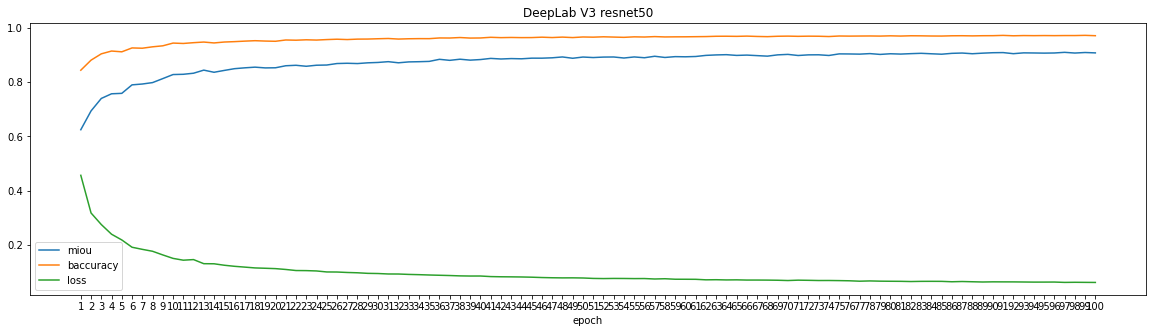

In [25]:
log_epoch = pd.read_csv('result/' + filename + '/val_log_epoch.csv', names = ['epoch', 'file_name', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(20, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'baccuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

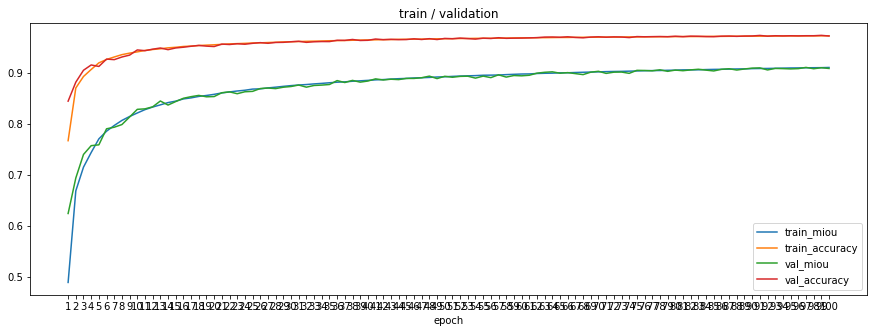

In [26]:
train_log_epoch = pd.read_csv('result/' + filename + '/train_log_epoch.csv', names = ['epoch', 'loss', 'accuracy', 'miou'])
val_log_epoch = pd.read_csv('result/' + filename + '/val_log_epoch.csv', names = ['epoch', 'file_name', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(15, 5))
plt.plot(train_log_epoch['epoch'], train_log_epoch['miou'], label = 'train_miou')
plt.plot(train_log_epoch['epoch'], train_log_epoch['accuracy'], label = 'train_accuracy')
plt.plot(val_log_epoch['epoch'], val_log_epoch['miou'], label = 'val_miou')
plt.plot(val_log_epoch['epoch'], val_log_epoch['accuracy'], label = 'val_accuracy')
plt.xticks([i for i in range(1, train_log_epoch.shape[0]+1)])
plt.title("train / validation")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

## test

In [27]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [28]:
# Load best model

save_path = os.getcwd() + '/result/' + filename + '/'
result = [file for file in sorted(os.listdir(save_path), reverse=True) if file[13:] == 'checkpoint.pth.tar' ]

In [29]:
bestmodel = result[0] # 최신모델

In [30]:
checkpoint = torch.load(save_path + bestmodel) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], filename + bestmodel))

Loaded best model weights (epoch 100) from 06_resnet_50210606_13:07_checkpoint.pth.tar


In [31]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
loss_running = AverageMeter('Loss', ':.4e')
acc_running = AverageMeter('Accuracy', ':.3f')  
iou = iouCalc(classLabels, validClasses, voidClass = 11)
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

batch_loss = 0.0
for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 141/141 [00:15<00:00,  9.39it/s]

classes           IoU
---------------------
Pole          : 0.501
SignSymbol    : 0.664
Bicyclist     : 0.811
Pedestrian    : 0.709
Building      : 0.922
Fence         : 0.774
Pavement      : 0.874
Road          : 0.973
Car           : 0.904
Sky           : 0.931
Tree          : 0.848
---------------------
Mean IoU      : 0.810
---------------------
loss : 0.6782 acc : 0.9382 miou : 0.8102
